In [250]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [251]:
# figure aesthetics
plt.style.use('ggplot')
sns.set_context('talk')
sns.set_style({'axes.spines.right': False,
             'axes.spines.top': False,
             'axes.edgecolor': 'black'})

# Importing and cleaning data

In [252]:
df = pd.read_csv('./data/KaggleV2-May-2016.csv')

In [253]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Let's rename a couple of columns.

In [254]:
df.rename(columns={'Handcap' : 'Handicap', 'Neighbourhood' : 'Neighborhood'}, inplace=True)

The PatientId column should probably be an integer number.

In [255]:
df['PatientId'] = df['PatientId'].astype(int)

How many patints are there?

In [256]:
df['PatientId'].nunique()

62299

Let's look at all the datatypes

In [257]:
df.dtypes

PatientId          int64
AppointmentID      int64
Gender            object
ScheduledDay      object
AppointmentDay    object
Age                int64
Neighborhood      object
Scholarship        int64
Hipertension       int64
Diabetes           int64
Alcoholism         int64
Handicap           int64
SMS_received       int64
No-show           object
dtype: object

Let's set the date columns to datetime format.

In [258]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

Now let check for nan and duplicates:

In [259]:
if ~df.duplicated().any():
    print("No duplicate rows.")

No duplicate rows.


In [260]:
if ~df.isna().any().all():
    print("No NaNs.")

No NaNs.


Finally, let's check for outliers.

In [261]:
# are genders binary?
print(df['Gender'].unique())

['F' 'M']


Text(0.5, 0, 'Age')

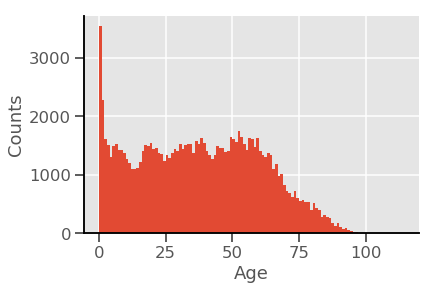

In [262]:
# what is the age distribution?
plt.hist(df['Age'], np.arange(0,115,1));
plt.ylabel('Counts')
plt.xlabel("Age")

Age distribution looks reasonble. A lot of the patients are new-borns apparently. What are the actual stats?

In [263]:
df['Age'].describe()

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

Look's like we have a couple of outliers. The minimum patient age is -1, how many times does it happen?

In [264]:
(df['Age'] < 0).sum()

1

Let's drop it.

In [265]:
df = df.loc[df['Age'] >= 0 ]

How many patients are over 100?

In [266]:
(df['Age'] > 100).sum()

7

Only 7. Compared to around 60k patients, so I'll drop these as well.

In [267]:
df = df.loc[df['Age'] <= 100]

Let's check out the other numerical data.

In [268]:
df.select_dtypes(np.number).nunique()

PatientId         62294
AppointmentID    110519
Age                 101
Scholarship           2
Hipertension          2
Diabetes              2
Alcoholism            2
Handicap              5
SMS_received          2
dtype: int64

Looks like the other variables are binary except for Handicap.

In [269]:
df['Handicap'].unique()

array([0, 1, 2, 3, 4])

In [270]:
df['Handicap'].value_counts()

0    108282
1      2038
2       183
3        13
4         3
Name: Handicap, dtype: int64

These values could just mean different kinds or levels so I'll leave them and trust the data on this one.

# Exploring

## Time statistics

Let's create a column for the duration between scheduled day and appointment date (in days).

In [271]:
df['waitingDays'] = (df['AppointmentDay'].dt.date - df['ScheduledDay'].dt.date).dt.days

What is the range of dates?

In [273]:
print(df.AppointmentDay.apply(['min','max', lambda x: np.max(x) - np.min(x)]))

min         2016-04-29 00:00:00+00:00
max         2016-06-08 00:00:00+00:00
<lambda>             40 days 00:00:00
Name: AppointmentDay, dtype: object


In [274]:
print(df.ScheduledDay.apply(['min','max', lambda x: np.max(x) - np.min(x)]))

min         2015-11-10 07:13:56+00:00
max         2016-06-08 20:07:23+00:00
<lambda>            211 days 12:53:27
Name: ScheduledDay, dtype: object


How does waiting time correlate with showing or not showing?

In [275]:
x = df['waitingDays'].values
y = df['No-show'].map({'No':0, 'Yes':1}).values
print(f"The correlation coefficient between waiting time and no-show is {np.corrcoef(x,y)[0,1].round(2)}.")

The correlation coefficient between waiting time and no-show is 0.19.


Non-negligible but not as much as I thought. I wonder if the distance, conveyed by the neighborhood, is the main cause of someone missing their appointment. Let's also look at time of day, day of week and day of month.

To facilitate the grouping calculations, I'll define a function that returns the percentage of no-shows from a given group. This is meant to be used with `.agg` in `groupby`'s or `aggfunc` in `pivot_tables`'s.

In [276]:
def noshow_perc(x):
    """Returns percentage of no-shows when performing groupby operations."""
    return 100*(x=='Yes').sum()/len(x)

Let's look at a curve of no-show percentage by waiting days. Because the curve is noisy, especially at high values, I'll apply a rolling mean.

(0, 100)

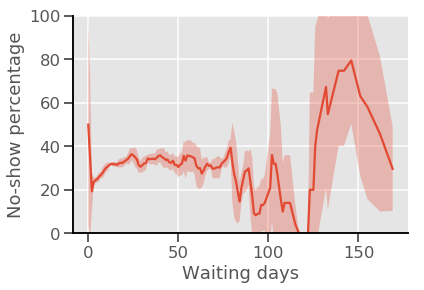

In [365]:
gdf = df.groupby('waitingDays').agg({'No-show' : noshow_perc}).rolling(5, center=True)
x = gdf.mean().index
y = gdf.mean()['No-show']
yerr = gdf.std()['No-show']

plt.plot(x,y)
plt.fill_between(x,y-yerr,y+yerr, alpha=0.3)
plt.ylabel("No-show percentage");
plt.xlabel('Waiting days')
plt.ylim(0,100)

The band shows the uncertainty of the rolling mean. Clearly there's a big spike in no-shows when the appointment and scheduling are too far apart. Let's move on to weekdays.

In [277]:
# for reordering - no appointments on Sundays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

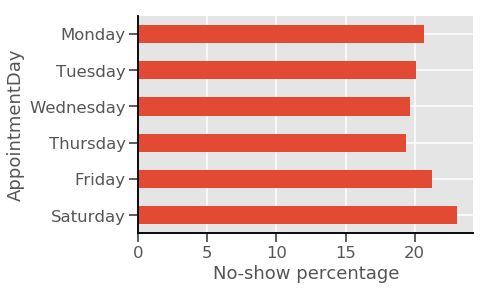

In [278]:
# grouping by weekday, calculating percentage of no-shows and plotting
# a horizontal bar chart.
df.groupby(df['AppointmentDay'].dt.weekday_name).agg(
    {'No-show':noshow_perc}
    ).loc[weekdays[::-1]].plot.barh(legend=False);
plt.xlabel('No-show percentage');

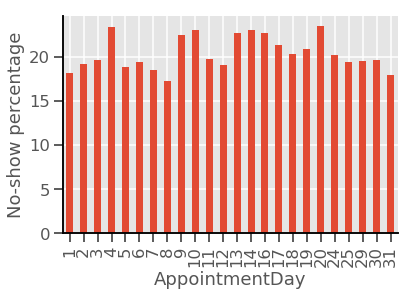

In [316]:
# grouping by day of month, calculating percentage of no-shows and plotting
# a vertical bar chart.
df.groupby(df['AppointmentDay'].dt.day).agg(
    {'No-show':noshow_perc}
    ).plot.bar(legend=False);
plt.ylabel('No-show percentage');

Unfortunately there is no appointment hour data, which I bet would correlated with no-shows. There is Scheduling hour though, so let's look at the Scheduling data.

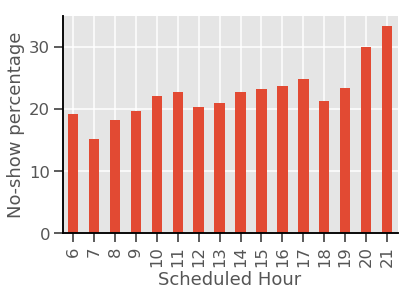

In [319]:
# grouping by day of month, calculating percentage of no-shows and plotting
# a vertical bar chart.
df.groupby(df['ScheduledDay'].dt.hour).agg(
    {'No-show':noshow_perc}
    ).plot.bar(legend=False);
plt.xlabel('Scheduled Hour')
plt.ylabel('No-show percentage');

Interestingly, the time someone made the appointment (not the appointment time) seems to correlated with no-show percentage. The correlation coefficient calculated below doesn't really convey it.

In [329]:
np.corrcoef(df.ScheduledDay.dt.hour, df['No-show'].map({'Yes':1,'No':0}))[0,1]

0.06068797817069846

### Neighborhoods with the most no-show

We can quickly look at noshow percentage as a function of neighborhood.

In [121]:
df.groupby('Neighborhood').agg({'No-show': noshow_perc}).sort_values('No-show', ascending=False).head(10)

,No-show
Neighborhood,
ILHAS OCEÂNICAS DE TRINDADE,100.000000
SANTOS DUMONT,28.918495
SANTA CECÍLIA,27.455357
SANTA CLARA,26.482213
ITARARÉ,26.266363
JESUS DE NAZARETH,24.395373
HORTO,24.000000
ILHA DO PRÍNCIPE,23.477493
CARATOÍRA,23.040936


The distribution for average number of no-shows/neighborhood is shown bellow. Looks fairly Gaussian so the fluctuations could be due to noise. I wouldn't read too much into it since each group (neighborhood) has a different number of samples (appointments).

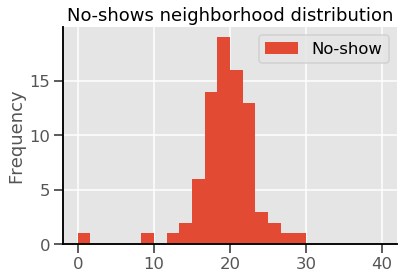

In [122]:
plt.title('No-shows neighborhood distribution')
ax = plt.gca()
df.groupby('Neighborhood').agg({'No-show': noshow_perc}
                              ).plot.hist(bins=np.linspace(0,40,25),ax=ax);

### Let's go ahed and look at stats for other groups.
First we group by age and gender with a pivot table, calculate the no-show percentage, apply a rolling mean to clean up the plot and then execute the plotting method.

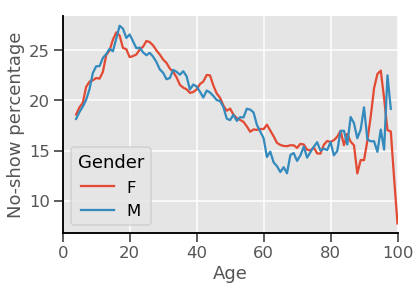

In [169]:
ax = df.pivot_table(index='Age', columns='Gender', values='No-show', aggfunc=noshow_perc).rolling(5).mean().plot()
ax.set_ylabel('No-show percentage');

There doesn't seem to be an appreciable difference by gender. The age curve seems fairly well defined, though. People around 18 years old tend to miss appointments the most while people around 65 the least.

We can keep looking at these curves, but I'll let the machine lerning output inform us on the important features. For now, let's look at the correlation between every numerical variable and no-show.

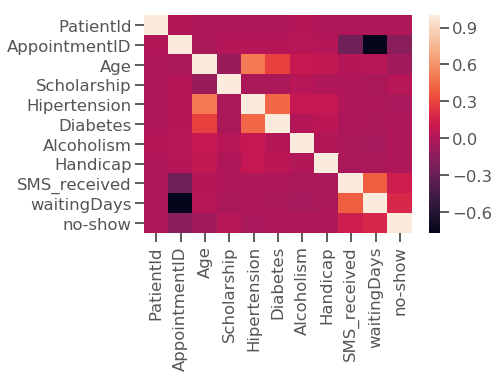

In [370]:
df['no-show'] = 1
df.loc[df['No-show']=='No','no-show']=0
sns.heatmap(df.corr())